# Nuclear segmentation with emerin ring and spot detection

Scripts to detect nuclei from 4d images (z,x,y,c) where channel 0 is green spots and channel 1 is red emerin rings.
Mostly based on scripts from Lucien Hinderling, with some modifications and cleanup by Jennifer Semple

**Inputs**:

input_path and output_path. input_path is used to create a dataframe with paths to images and the following 
columns:

*filename	pos	timepoint	group	filepath	id*

example line:

*PMW989_embryos_pos1	pos1	1	PMW989	/mnt/external.data/MeisterLab/lhinder/PMW989_t...	PMW989_pos1_1*

the id column is used to name images in the output_path directories

**Outputs**:

segmentation masks (.tif files) in output_path/segementation/

distance masks (.tif files) in output_path/edt/

nuclear measurements (.csv files) in output_path/nuclei/

intensity measurements for nuclei with arrays of intensity/distance from middle slice of each nuclear mask (.pkl files) in output_path/dist/ 

qc plots of segmentation on original image (segmentation_XXX.pdf), individual masked nuclei (cropped_nuclei_XXX.pdf) in output_path/qc/

spot detection (.csv files, doesn't work very well) in output_path/spots/ with some qc in output_path/qc/spots*.pdf and spotGMM*.pdf




In [1]:
import napari
import torch
import skimage.io as io
from skimage.measure import regionprops_table, regionprops
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import cellpose
from cellpose import models
import edt
import glob
import os
import tqdm
from matplotlib_scalebar.scalebar import ScaleBar
import gc
from nd2reader import ND2Reader
from threading import Thread
from multiprocessing import Process
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter


anisotropy = (3,1,1) # Relative scale of (Z,X,Y) axes

nucChannel = 0 # red emerin rings
spotChannel = 1 # green spots

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

In [2]:

raw_input_path = '/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/'
denoised_input_path = raw_input_path+'N2V_1268RG_1273RG/denoised/'
output_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/DPY27/'

#raw_input_path = '/Volumes/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/'
#denoised_input_path = raw_input_path+'N2V_1268RG_1273RG/denoised/'
#output_path = '/Volumes/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/DPY27/'

if not os.path.exists(output_path+"/qc"):
    os.makedirs(output_path+"/qc")

if not os.path.exists(output_path+"/segmentation"):
    os.makedirs(output_path+"/segmentation")

if not os.path.exists(output_path+"/edt"):
    os.makedirs(output_path+"/edt")

if not os.path.exists(output_path+"/spots"):
    os.makedirs(output_path+"/spots")

if not os.path.exists(output_path+"/nuclei"):
    os.makedirs(output_path+"/nuclei")

if not os.path.exists(output_path+"/dist"):
    os.makedirs(output_path+"/dist")


raw_file_name_pattern = "/*.nd2"
denoised_file_name_pattern = "/*_n2v.tif"
raw_filepaths = sorted(glob.glob(raw_input_path + raw_file_name_pattern,recursive=True))
print(f"Found {len(raw_filepaths)} *.nd2 files.")

Found 24 *.nd2 files.


Generate data frame of file paths with metadata

In [3]:
df = pd.DataFrame()
df['filename'] = [os.path.basename(filepath)[:-4] for filepath in raw_filepaths]
tmpdate = [os.path.normpath(filepath).split(os.sep)[-2] for filepath in raw_filepaths]
df['date'] = pd.Series([exp.split('_')[0] for exp in tmpdate])
df['experiment'] = pd.Series([exp.split('_')[1] for exp in tmpdate])
df['strain'] = [os.path.normpath(filepath).split(os.sep)[-3] for filepath in raw_filepaths]
df['protein'] = [os.path.normpath(filepath).split(os.sep)[-4] for filepath in raw_filepaths]
df['id'] = df['protein'] + '_' + df['experiment'] + '_' + df['filename'] 
df['raw_filepath'] = raw_filepaths
df['denoised_filepath'] = [denoised_input_path+filename+'_n2v.tif' for filename in df['filename']]

df.to_csv(output_path+'fileList.csv',index=False)

Load model

In [4]:
torch.cuda.device(0)

# using gpu, on server
#model = models.CellposeModel(pretrained_model='/mnt/external.data/MeisterLab/lhinder/segmentation_3d_anja/code/worms_1000epochs_v0', gpu=False, device =torch.device('cuda:0'))

# no gpu, on server
model = models.CellposeModel(pretrained_model='/mnt/external.data/MeisterLab/lhinder/segmentation_3d_anja/code/worms_1000epochs_v0')

# no gpu, from local machine with izbkingston mounted 
#model = models.CellposeModel(pretrained_model='/Volumes/external.data/MeisterLab/lhinder/segmentation_3d_anja/code/worms_1000epochs_v0')

/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fil

## Functions for nuclear segmentation and qc

In [83]:
# Disable do_3D, there is a bug. 2D and stitching with overlap works much better.
# Takes around 7min for the whole image on the macbook
def segment_nuclei(img, model):
    masks,flows,styles = model.eval(img,do_3D=False,stitch_threshold=0.3,cellprob_threshold =0,diameter =36)
    return masks,flows,styles


def calc_distance_mask(masks,anisotropy):
    '''Calculate the distance map from the nuclei-edge towards the center of nucleus'''
    masks_edt = edt.edt(masks,anisotropy = anisotropy)
    return masks_edt


# 

def plot_qc_nuclei_crop(df, index, df_region_props, img, display = False, seed=1):
    nb_nuc = 10
    np.random.seed(seed)
    indices_to_sample = np.random.choice(range(len(df_region_props)),size = nb_nuc,replace = False)
    # sort indeces in descending order of area

    widths=[df_region_props['image'][i].shape[1] for i in indices_to_sample]

    fig, axs = plt.subplots(nrows = 2, ncols = nb_nuc, figsize = (15,5),dpi = 250, 
                            sharex=False, sharey=False, width_ratios=widths)
    fig.suptitle(f'Cropped nuclei {df.id.iloc[index]}', fontsize=16)

    for i,sample in enumerate(indices_to_sample):
        intensity_image = df_region_props['intensity_image'][sample][:,:,:,spotChannel] #show first spot channel
        image = df_region_props['image'][sample]
        mx = np.ma.masked_array(intensity_image,mask = ~image)
        z_height = image.shape[0] 
        axs[0,i].imshow(mx[int(z_height/2)])
        axs[0,i].spines['top'].set_visible(False)
        axs[0,i].spines['right'].set_visible(False)
        axs[0,i].spines['bottom'].set_visible(False)
        axs[0,i].spines['left'].set_visible(False)
        axs[0,i].get_xaxis().set_ticks([])
        axs[0,i].get_yaxis().set_ticks([])

    for i,sample in enumerate(indices_to_sample):
        intensity_image = df_region_props['intensity_image'][sample][:,:,:,nucChannel] #show second nuclear channel
        image = df_region_props['image'][sample]
        mx = np.ma.masked_array(intensity_image,mask = ~image)
        z_height = image.shape[0]
        axs[1,i].imshow(mx[int(z_height/2)])
        axs[1,i].spines['top'].set_visible(False)
        axs[1,i].spines['right'].set_visible(False)
        axs[1,i].spines['bottom'].set_visible(False)
        axs[1,i].spines['left'].set_visible(False)
        axs[1,i].get_xaxis().set_ticks([])
        axs[1,i].get_yaxis().set_ticks([])

        if i == nb_nuc-1:
            scalebar = ScaleBar(0.065, "um", length_fraction=1, box_alpha=0.7,color='black',location='lower right',height_fraction = 0.05,border_pad =-1)
            axs[1,i].add_artist(scalebar)

    #plt.tight_layout()
    fig.savefig(output_path + 'qc/cropped_nuclei_'+df.id.iloc[index]+'.pdf')
    if display == False:
        plt.close()
    else:
        plt.show()


#def plot_qc_segmentation(img,masks,index,df,display_plot=False):
#     fig, axs = plt.subplots(2,3,figsize = (7,5),dpi= 450)
#     plt.tight_layout()
#     fig.suptitle(f'Segmentation for {df.id.iloc[index]}', fontsize=10)
#     axs[0,0].imshow(masks[10,:,:]>0,cmap = 'gray_r')
#     axs[1,0].set_title('z=10', fontsize=8)
#     axs[0,1].imshow(masks[30,:,:]>0,cmap = 'gray_r')
#     axs[1,1].set_title('z=30', fontsize=8)
#     axs[0,2].imshow(masks[45,:,:]>0,cmap = 'gray_r')
#     axs[1,2].set_title('z=45', fontsize=8)

#     axs[1,0].imshow(img[nucChannel,10,:,:],cmap = 'gray_r')
#     axs[1,1].imshow(img[nucChannel,30,:,:],cmap = 'gray_r')
#     axs[1,2].imshow(img[nucChannel,45,:,:],cmap = 'gray_r')


#     for axss in axs:
#         for ax in axss:
#             ax.set_xticks([])
#             ax.set_yticks([])

#     fig.savefig(output_path + 'qc/segmentation_'+df.id.iloc[index]+'.pdf')
#     if display_plot:
#         plt.show()
#     else:
#         fig.savefig(output_path + 'qc/segmentation_'+df.id.iloc[index]+'.pdf')
#         plt.close()


def plot_qc_segmentation_xyz1(img,masks,index,df,display_plot=False, plotContours=False):
    nucChannel = 0
    num_z=img.shape[1]
    num_y=img.shape[2]
    num_x=img.shape[3]

    fig = plt.figure(layout='constrained',dpi=450,figsize = (10,10))
    fig.suptitle(f'Segmentation for {df.id.iloc[index]}', fontsize=10)
    subfigs = fig.subfigures(2, 1, wspace=0.1)

    axsTop = subfigs[0].subplots(2, 3,sharex=True, sharey=True)
    #xy
    axsTop[0,0].imshow(masks[int(num_z*0.3),:,:]>0,cmap = 'grey_r')
    axsTop[1,0].set_title('z='+str(int(num_z*0.3)), fontsize=8)
    axsTop[0,1].imshow(masks[int(num_z*0.5),:,:]>0,cmap = 'grey_r')
    axsTop[1,1].set_title('z='+str(int(num_z*0.5)), fontsize=8)
    axsTop[0,2].imshow(masks[int(num_z*0.7),:,:]>0,cmap = 'gray_r')
    axsTop[1,2].set_title('z='+str(int(num_z*0.7)), fontsize=8)

    axsTop[1,0].imshow(img[nucChannel,int(num_z*0.3),:,:],cmap = 'gray_r')
    axsTop[1,1].imshow(img[nucChannel,int(num_z*0.5),:,:],cmap = 'gray_r')
    axsTop[1,2].imshow(img[nucChannel,int(num_z*0.7),:,:],cmap = 'gray_r')

    if plotContours:
        axsTop[1,0].contour(masks[int(num_z*0.3),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,1].contour(masks[int(num_z*0.5),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,2].contour(masks[int(num_z*0.7),:,:], [0.5], linewidths=0.5, colors='r')



    for axss in axsTop:
        for ax in axss:
            #ax.set_xlim(0,num_x)
            #ax.set_ylim(0,num_y)
            ax.set_xticks([])
            ax.set_yticks([])

    axsBottom = subfigs[1].subplots(4, 3,sharex=True,sharey=True)
    #xz
    axsBottom[0,0].imshow(masks[:,int(num_y*0.3),:]>0,cmap = 'grey_r')
    axsBottom[1,0].set_title('y='+str(int(num_y*0.3)), fontsize=8)
    axsBottom[0,1].imshow(masks[:,int(num_y*0.5),:]>0,cmap = 'grey_r')
    axsBottom[1,1].set_title('y='+str(int(num_y*0.5)), fontsize=8)
    axsBottom[0,2].imshow(masks[:,int(num_y*0.7),:]>0,cmap = 'gray_r')
    axsBottom[1,2].set_title('y='+str(int(num_y*0.7)), fontsize=8)

    axsBottom[1,0].imshow(img[nucChannel,:,int(num_y*0.3),:],cmap = 'gray_r')
    axsBottom[1,1].imshow(img[nucChannel,:,int(num_y*0.5),:],cmap = 'gray_r')
    axsBottom[1,2].imshow(img[nucChannel,:,int(num_y*0.7),:],cmap = 'gray_r')

    if plotContours:
        axsBottom[1,0].contour(masks[:,int(num_y*0.3),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,1].contour(masks[:,int(num_y*0.5),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,2].contour(masks[:,int(num_y*0.7),:], [0.5], linewidths=0.5, colors='r')


    #yz
    axsBottom[2,0].imshow(masks[:,:,int(num_x*0.3)]>0,cmap = 'grey_r')
    axsBottom[3,0].set_title('x='+str(int(num_x*0.3)), fontsize=8)
    axsBottom[2,1].imshow(masks[:,:,int(num_x*0.5)]>0,cmap = 'grey_r')
    axsBottom[3,1].set_title('x='+str(int(num_x*0.5)), fontsize=8)
    axsBottom[2,2].imshow(masks[:,:,int(num_x*0.7)]>0,cmap = 'gray_r')
    axsBottom[3,2].set_title('x='+str(int(num_x*0.7)), fontsize=8)

    axsBottom[3,0].imshow(img[nucChannel,:,:,int(num_x*0.3)],cmap = 'gray_r')
    axsBottom[3,1].imshow(img[nucChannel,:,:,int(num_x*0.5)],cmap = 'gray_r')
    axsBottom[3,2].imshow(img[nucChannel,:,:,int(num_x*0.7)],cmap = 'gray_r')

    if plotContours:
        axsBottom[3,0].contour(masks[:,:,int(num_x*0.3)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,1].contour(masks[:,:,int(num_x*0.5)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,2].contour(masks[:,:,int(num_x*0.7)], [0.5], linewidths=0.5, colors='r')

    for axss in axsBottom:
        for ax in axss:
            #ax.set_ylim(0,num_z)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    if display_plot:
        plt.show()
    else:
        fig.savefig(output_path + 'qc/segmentation_'+df.id.iloc[index]+'.pdf')
        plt.close()

def plot_qc_segmentation_xyz(img,masks,index,df,display_plot=False, plotContours=False):
    nucChannel = 0
    num_z=img.shape[1]
    num_y=img.shape[2]
    num_x=img.shape[3]
    nlabel=100

    fig = plt.figure(layout='constrained',dpi=450,figsize = (10,10))
    fig.suptitle(f'Segmentation for {df.id.iloc[index]}', fontsize=10)
    subfigs = fig.subfigures(2, 1, wspace=0.1)

    axsTop = subfigs[0].subplots(2, 3,sharex=True, sharey=True)
    #xy
    axsTop[0,0].imshow(label2rgb(masks[int(num_z*0.3),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,0].set_title('z='+str(int(num_z*0.3)), fontsize=8)
    axsTop[0,1].imshow(label2rgb(masks[int(num_z*0.5),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,1].set_title('z='+str(int(num_z*0.5)), fontsize=8)
    axsTop[0,2].imshow(label2rgb(masks[int(num_z*0.7),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,2].set_title('z='+str(int(num_z*0.7)), fontsize=8)

    axsTop[1,0].imshow(img[nucChannel,int(num_z*0.3),:,:],cmap = 'gray_r')
    axsTop[1,1].imshow(img[nucChannel,int(num_z*0.5),:,:],cmap = 'gray_r')
    axsTop[1,2].imshow(img[nucChannel,int(num_z*0.7),:,:],cmap = 'gray_r')

    if plotContours:
        axsTop[1,0].contour(masks[int(num_z*0.3),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,1].contour(masks[int(num_z*0.5),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,2].contour(masks[int(num_z*0.7),:,:], [0.5], linewidths=0.5, colors='r')



    for axss in axsTop:
        for ax in axss:
            #ax.set_xlim(0,num_x)
            #ax.set_ylim(0,num_y)
            ax.set_xticks([])
            ax.set_yticks([])

    axsBottom = subfigs[1].subplots(4, 3,sharex=True,sharey=True)
    #xz
    axsBottom[0,0].imshow(label2rgb(masks[:,int(num_y*0.3),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,0].set_title('y='+str(int(num_y*0.3)), fontsize=8)
    axsBottom[0,1].imshow(label2rgb(masks[:,int(num_y*0.5),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,1].set_title('y='+str(int(num_y*0.5)), fontsize=8)
    axsBottom[0,2].imshow(label2rgb(masks[:,int(num_y*0.7),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,2].set_title('y='+str(int(num_y*0.7)), fontsize=8)

    axsBottom[1,0].imshow(img[nucChannel,:,int(num_y*0.3),:],cmap = 'gray_r')
    axsBottom[1,1].imshow(img[nucChannel,:,int(num_y*0.5),:],cmap = 'gray_r')
    axsBottom[1,2].imshow(img[nucChannel,:,int(num_y*0.7),:],cmap = 'gray_r')

    if plotContours:
        axsBottom[1,0].contour(masks[:,int(num_y*0.3),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,1].contour(masks[:,int(num_y*0.5),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,2].contour(masks[:,int(num_y*0.7),:], [0.5], linewidths=0.5, colors='r')


    #yz
    axsBottom[2,0].imshow(label2rgb(masks[:,:,int(num_x*0.3)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,0].set_title('x='+str(int(num_x*0.3)), fontsize=8)
    axsBottom[2,1].imshow(label2rgb(masks[:,:,int(num_x*0.5)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,1].set_title('x='+str(int(num_x*0.5)), fontsize=8)
    axsBottom[2,2].imshow(label2rgb(masks[:,:,int(num_x*0.7)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,2].set_title('x='+str(int(num_x*0.7)), fontsize=8)

    axsBottom[3,0].imshow(img[nucChannel,:,:,int(num_x*0.3)],cmap = 'gray_r')
    axsBottom[3,1].imshow(img[nucChannel,:,:,int(num_x*0.5)],cmap = 'gray_r')
    axsBottom[3,2].imshow(img[nucChannel,:,:,int(num_x*0.7)],cmap = 'gray_r')

    if plotContours:
        axsBottom[3,0].contour(masks[:,:,int(num_x*0.3)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,1].contour(masks[:,:,int(num_x*0.5)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,2].contour(masks[:,:,int(num_x*0.7)], [0.5], linewidths=0.5, colors='r')

    for axss in axsBottom:
        for ax in axss:
            #ax.set_ylim(0,num_z)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    if display_plot:
        plt.show()
    else:
        fig.savefig(output_path + 'qc/segmentation_'+df.id.iloc[index]+'.pdf')
        plt.close()

In [6]:
## Run the segmentation script on all images (reserve more than 24GB!)
# this produces segmentation, segmentation_qc and edt files
def run_nuclear_segmentation(indices, df):
    for index in tqdm.tqdm(indices):
        # Load the data
        #with ND2Reader(df.filepath.iloc[index]) as images:
        #    images.bundle_axes = ['z','x','y','c']
        #    img = images[0]
        #img = io.imread(df.denoised_filepath.iloc[index])
        img = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
        img = img.get_image_data("CZYX", T=0)


        # Segment nuclei 
        masks,flows,styles = segment_nuclei(img[nucChannel,:,:,:],model) # Run the segmentation
        plot_qc_segmentation_xyz(img,masks,index, df, display_plot = False)                         # Create qc plot
        #io.imsave(output_path+'segmentation/'+df.id.iloc[index]+'.tif',masks,check_contrast=False) #store segmentation
        OmeTiffWriter.save(masks, output_path+'segmentation/'+df.id.iloc[index]+'.tif')

        del flows
        del styles
        gc.collect()
        
        # Calculate edt 
        masks_edt = calc_distance_mask(masks,anisotropy)
        #io.imsave(output_path+'edt/'+df.id.iloc[index]+'.tif',masks_edt,check_contrast=False) #store segmentation
        OmeTiffWriter.save(masks_edt, output_path+'edt/'+df.id.iloc[index]+'.tif')

        del masks
        del masks_edt
        gc.collect()
        continue


In [7]:
## read images
## crop the nuclei slices
## calculate EDT transform
## for each nuclei loop over all distances (1:40) and take mean
## array of distance/intensity measurements are taken only for middle slice of mask (?)

## nucleus_id | nucleus volume | [1:20] mean intensities | group | ...


def run_dist_analysis(indices,df):
    for index in tqdm.tqdm(indices):
        
        df_nuclei = pd.DataFrame()
        print(df.iloc[index].raw_filepath)
        
        masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'.tif', reader=bioio_tifffile.Reader)
        masks = masks.get_image_data("ZYX", T=0, C=0)

        img = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
        img = img.get_image_data("ZYXC", T=0)
            
          
        df_region_props = regionprops_table(masks,img, properties = ['label', 'area','image','intensity_image'])
        df_region_props = pd.DataFrame(df_region_props)

        if len(df_region_props)>=10:
            plot_qc_nuclei_crop(df, index, df_region_props, img, display = False) 

        for i in range(len(df_region_props)):
            df_nuclei_temp = pd.DataFrame()

            intensity_image_spots = df_region_props['intensity_image'][i][:,:,:,spotChannel] #show spot channel
            intensity_image_nuclei = df_region_props['intensity_image'][i][:,:,:,nucChannel] #show nuclear ring channel

            image = df_region_props['image'][i]
            mx = np.ma.masked_array(intensity_image_spots,mask = ~image)

            # Extract the intensity per distance
            intensity_image = df_region_props['intensity_image'][i][:,:,:,spotChannel] #show first spot channel
            image = df_region_props['image'][i]
            mx_spots = np.ma.masked_array(intensity_image_spots,mask = ~image)
            mx_nuclei = np.ma.masked_array(intensity_image_nuclei,mask = ~image)
            mx_mask = np.ma.masked_array(image,mask = ~image)

            z_height = image.shape[0]

            slice_spots = mx_spots[int(z_height/2)]
            slice_nuclei = mx_nuclei[int(z_height/2)]
            slice_mask = mx_mask[int(z_height/2)]

            slice_mask_edt = edt.edt(slice_mask)
            slice_mask_edt = np.ma.masked_array(slice_mask_edt,mask = ~(slice_mask_edt>0)) 

            results = regionprops_table(slice_mask_edt.astype('int'),slice_nuclei,properties=['label','intensity_mean'])
            intensity_dist_nuclei = results['intensity_mean']

            results = regionprops_table(slice_mask_edt.astype('int'),slice_spots,properties=['label','intensity_mean'])
            intensity_dist_spots = results['intensity_mean']
            dist = results['label']

            df_nuclei_temp['label']  = [df_region_props.label.iloc[i]]
            df_nuclei_temp['bb_dimZ']  = [mx.shape[0]]
            df_nuclei_temp['bb_dimY']  = [mx.shape[1]]
            df_nuclei_temp['bb_dimX']  = [mx.shape[2]]
            df_nuclei_temp['mean'] = [np.ma.mean(mx)]
            df_nuclei_temp['median'] = [np.ma.median(mx)]
            df_nuclei_temp['std']=  [np.ma.std(mx)]
            df_nuclei_temp['sum']= [np.ma.sum(mx)]
            df_nuclei_temp['variance']= [np.ma.var(mx)]
            df_nuclei_temp['max'] = [np.ma.max(mx)]
            df_nuclei_temp['min'] = [np.ma.min(mx)]
            df_nuclei_temp['volume'] = [np.sum(mx.mask)]
            df_nuclei_temp['id'] = [df.id.iloc[index]]
            df_nuclei_temp['intensity_dist_nuclei'] = [intensity_dist_nuclei]  # this is the emerin ring channel intensity on central slice
            df_nuclei_temp['intensity_dist_spots'] = [intensity_dist_spots] # this is the spot channel but not actual detected spots
            df_nuclei_temp['intensity_dist'] = [dist]  # this is the distance from the edge of the nucleus

            df_nuclei = pd.concat([df_nuclei,df_nuclei_temp])
        # save as pickle because has array stored in Dataframe
        df_nuclei.to_pickle(output_path+'dist/'+df.id.iloc[index]+'.pkl') # Back up the DF for this FOV

        # save with metadata as csv for simple viewing 
        df_nuclei_for_csv = pd.merge(df_nuclei,df,on='id',how='left')
        df_nuclei_for_csv.drop( columns = [ 'intensity_dist_nuclei','intensity_dist_spots','intensity_dist' ], axis=1, inplace=True)
        df_nuclei_for_csv.to_csv(output_path+'nuclei/'+df.id.iloc[index]+'.csv', index=False)



## Functions for spot detection and qc

In [8]:
def find_spots(img,diameter=(9,5,5),separation=(3,2,2)):
    '''Find protein clusters of a certain size. Method is very sensitive, be sure to filter the spots afterwards using the signal value.
    Input: img -> 3D array from C0 containing
    Output: pandas.df containing data with all the detected spots.
            x,y,z: centroid of spot in image coordinates (px space)
            mass: total integrated brightness of the blob
            size: radius of gyration of its Gaussian-like profile
            ecc: eccentricity
            raw_mass: integrated brightness in raw_image '''

    #features = tp.locate(img, diameter=diameter, engine='numba',minmass = 10,percentile = 0.95,max_iterations=3,preprocess = True) #check 
    features = tp.locate(img[:,:,:], diameter, minmass=None, maxsize=None, separation=separation, noise_size=1, smoothing_size=None, threshold=None, invert=False, percentile=95, topn=None, preprocess=True, max_iterations=3, filter_before=None, filter_after=None, characterize=True, engine='numba')
    return features


def extract_spot_features(features,masks,masks_edt):
    '''For each spot get the label of the corresponding nucleus and distance to its envelope.'''

    for feature in features.iterrows():
        index = feature[0]
        x = round(feature[1].x)
        y = round(feature[1].y)
        z = round(feature[1].z)
        dist = masks_edt[z,y,x]
        label = masks[z,y,x]
        features.loc[index,'dist'] = dist
        features.loc[index,'label'] = int(label)
        
    return features
#features = extract_spot_features(features,masks,masks_edt)

def filter_spots(features, measure = 'signal', signal_strength = 0.1):
    '''Remove all spots that lie outside of a nucleus (or where nucleus is not detected.
       Remove all spots with signal<signal_strength'''
    features_filt = features[(features['dist']>0)&(features[measure]>signal_strength)]
    return features_filt

In [84]:
def plot_qc_spot_detection(df, index, df_features, img, display_plot = False,
                            measure = 'signal', thresholds = [1 ,2.5, 5, 10]):
    z_projection = np.max(img[:,:,:], axis = 0)
    #masks_z_projection = np.max(masks[:,:,:], axis = 0)
    features_filt_01 = filter_spots(df_features, measure = measure, signal_strength = thresholds[0])
    features_filt_02 = filter_spots(df_features, measure = measure, signal_strength = thresholds[1])
    features_filt_03 = filter_spots(df_features, measure = measure, signal_strength =  thresholds[2])
    features_filt_04 = filter_spots(df_features, measure = measure, signal_strength = thresholds[3])


    fig, axs = plt.subplots(2,2,figsize = (6,7),dpi= 450)

    for axss in axs:
        for ax in axss:
            ax.set_xticks([])
            ax.set_yticks([])


    axs[0,0].imshow(z_projection, cmap = 'gray_r')
    axs[0,0].scatter(features_filt_01[['x']],features_filt_01[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[0,0].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[0,0].set_title(f'{measure}>{thresholds[0]} (n={len(features_filt_01)})', fontsize=8,y=-0.01)

    axs[0,1].imshow(z_projection, cmap = 'gray_r')
    axs[0,1].scatter(features_filt_02[['x']],features_filt_02[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[0,1].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[0,1].set_title(f'{measure}>{thresholds[1]} (n={len(features_filt_02)})', fontsize=8,y=-0.01)

    axs[1,0].imshow(z_projection, cmap = 'gray_r')
    axs[1,0].scatter(features_filt_03[['x']],features_filt_03[['y']], s = 0.3, linewidths=0.11, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[1,0].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[1,0].set_title(f'{measure}>{thresholds[2]} (n={len(features_filt_03)})', fontsize=8,y=-0.01)

    axs[1,1].imshow(z_projection, cmap = 'gray_r')
    axs[1,1].scatter(features_filt_04[['x']],features_filt_04[['y']], s = 0.3, linewidths=0.1, alpha = 1, edgecolors = 'red', facecolors='none')
    #axs[1,1].contour(masks_z_projection, [0.5], linewidths=0.5, colors='green')
    axs[1,1].set_title(f'{measure}>{thresholds[3]} (n={len(features_filt_04)})', fontsize=8,y=-0.01)

    plt.tight_layout()
    fig.suptitle(f'Spot detection for {df.filename.iloc[index]}', fontsize=10)
    #xs[0,0].imshow(masks[10,:,:]>0,cmap = 'gray_r')

    if display_plot:
        plt.show()
    else:
        fig.savefig(output_path + 'qc/spots_'+df.id.iloc[index]+'.pdf')
        plt.close()


In [85]:
def plot_qc_spot_threshold(index, df, display_plot=False, measure='signal'):
    ''' Fits mixed gaussian model to find threshold of spot mass

    Parameters:
    index (int): Index of image whose spots should be analysed
    df (pd.DataFrame): Data frame with list of image ids

    Returns:
    Saves a spotThreshold__.pdf for each image with a histogram, model fit and 
    threshold and returns image id, number of spots and the estimated threshold
    '''
    df_spots = pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv')
    x = np.array(df_spots[measure]).reshape(-1,1)
    gm =GaussianMixture(n_components=2,random_state=0).fit(x)
    mu1=gm.means_[0]
    mu2=gm.means_[1]
    sigma1=np.sqrt(gm.covariances_[0])
    sigma2=np.sqrt(gm.covariances_[1])
    threshold=np.round(float(mu1+3*sigma1),2)

    x_fit = np.linspace(0,max(x),100)
    y_fit = gm.score_samples(x_fit)

    plt.figure(figsize=(10,6))
    g = sns.histplot(data=df_spots,x=measure,stat='density',label="Data")
    plt.plot(x_fit,np.exp(y_fit),color='red',lw=1,ls='-',label="Fitted bimodal distribution")
    plt.axvline(mu1,0,1,color='red',lw=0.5,ls="--",label="Mean first gaussian")
    plt.axvline(threshold,0,1,color='red',lw=2,ls="-",label="Threshold (mean1+3*SD1)")
    plt.axvline(mu2,0,1,color='red',lw=0.5,ls=":",label="Mean second gaussian")
    plt.annotate('Threshold='+str(threshold),xy=(0.4,0.9),xycoords='axes fraction')
    plt.title('Distribution of spot '+measure+' as mixture of two gaussians')
    plt.xlabel(measure)
    plt.legend()

    if display_plot:
        plt.show()
    else:
        plt.savefig(output_path + 'qc/spotGMM_'+df.id.iloc[index]+'.pdf')
        plt.close()
    id=df.id.iloc[index]
    num_spot=len(df_spots)
    return(id, num_spot, threshold)


In [86]:
def run_spot_analysis(indices, df, useRaw=True, diameter=(9,5,5), separation=(3,2,2), qc_thresholds=[1,2.5,5,10]):
    '''Finds spots and estimates threshold'''
    ids = list()
    num_spots = list()
    thresholds = list()
    for index in tqdm.tqdm(indices):
        # Load the data
        # with ND2Reader(df.filepath.iloc[index]) as images:
        #     images.bundle_axes = ['z','x','y','c']
        #     img = images[0]
        if useRaw:
            img = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
            img = img.get_image_data("ZYX", T=0, C=spotChannel)
        else:
            img = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
            img = img.get_image_data("ZYX", T=0, C=spotChannel)

        # Run t
        masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'.tif', reader=bioio_tifffile.Reader)
        masks = masks.get_image_data("ZYX", T=0, C=0)

        masks_edt = BioImage(output_path+'edt/'+df.id.iloc[index]+'.tif', reader=bioio_tifffile.Reader)
        masks_edt = masks_edt.get_image_data("ZYX", T=0, C=0)

        # Find the spots (location given in image coordinate system )
        df_spots = find_spots(img[:,:,:],diameter = diameter,separation = separation)
        df_features = extract_spot_features(df_spots,masks,masks_edt)    # For all the spots calculate the features

        
        df_features = filter_spots(df_features, measure='signal', signal_strength = 0.0001)
        if len(df_features) == 0:
            print('EMPTY DF!!')
            print(df.filename.iloc[index])
            print('INDEX:' + str(index))
        else:
            print('found spots:' + str(len(df_features)))


        df_features.loc[:,'id'] = df.id.iloc[index]

        df_features.to_csv(output_path+'spots/'+df.id.iloc[index]+'.csv') # Back up the DF for this FOV
        
        #plot spots detected at different thresholds
        plot_qc_spot_detection(df, index, df_features, img, display_plot = False, measure = 'signal', thresholds = qc_thresholds) # Plot and save the QC of the spot detection

        # Use mixed Guassian model to separate background from true spots
        id, num_spot, threshold = plot_qc_spot_threshold(index, df, display_plot = False, measure = 'signal')
        ids.append(id)
        num_spots.append(num_spot)
        thresholds.append(threshold)
    
    df_thresholds = pd.DataFrame(data = {'id': ids, 'num_spots': num_spots, 'threshold':thresholds })
    df_thresholds.to_csv(output_path+'spotGMMthresholds.csv',index=False)
    return df_thresholds


def replot_spots_with_thresholds(indices, df, useRaw=True, qc_thresholds=[1,2.5,5,10]):
    '''Finds spots and estimates threshold'''
    for index in tqdm.tqdm(indices):
        # Load the data
        # with ND2Reader(df.filepath.iloc[index]) as images:
        #     images.bundle_axes = ['z','x','y','c']
        #     img = images[0]
        if useRaw:
            img = BioImage(df.raw_filepath.iloc[index], reader=bioio_nd2.Reader)
            img = img.get_image_data("ZYX", T=0, C=spotChannel)
        else:
            img = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
            img = img.get_image_data("ZYX", T=0, C=spotChannel)

        # Run t
        masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'.tif', reader=bioio_tifffile.Reader)
        masks = masks.get_image_data("ZYX", T=0, C=0)

        df_features =  pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv') # Back up the DF for this FOV
        
        #plot spots detected at different thresholds
        plot_qc_spot_detection(df,index, df_features, img, display_plot = False, measure = 'signal', thresholds = qc_thresholds) # Plot and save the QC of the spot detection


## Functions to gather results into single file

In [12]:
def collect_nuclear_segementation_data(indices, df, suffix = 'v001'):
    '''Collects nuclear intensity and intensity vs distance data for all nuclei in the dataset'''
    df_nuclei = pd.DataFrame()
    for index in tqdm.tqdm(indices):
        df_tmp = pd.read_csv(output_path+'nuclei/'+df.id.iloc[index]+'.csv')
        df_nuclei = pd.concat([df_nuclei,df_tmp])
    df_nuclei.to_csv(output_path+'nuclei_analysis_'+suffix+'.csv',index=False)



def collect_nuclear_distance_data(indices, df, suffix = 'v001'):
    '''Collects nuclear intensity and intensity vs distance data for all nuclei in the dataset'''
    df_dist = pd.DataFrame()
    for index in tqdm.tqdm(indices):
        df_tmp = pd.read_pickle(output_path+'dist/'+df.id.iloc[index]+'.pkl')
        df_dist = pd.concat([df_dist,df_tmp])
    df_dist.to_pickle(output_path+'dist_analysis_'+suffix+'.pkl')


def collect_spot_data(indices, df, suffix = 'v001'):
    '''Collects spot data for all images'''
    df_spots = pd.DataFrame()
    for index in tqdm.tqdm(indices):
        df_tmp = pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv')
        df_spots = pd.concat([df_spots,df_tmp])
    df_spots.to_csv(output_path+'spots_analysis_'+suffix+'.csv',index=False)


In [80]:
index=0

img = BioImage(df.denoised_filepath.iloc[index], reader=bioio_tifffile.Reader)
img = img.get_image_data("CZYX", T=0)

# Run t
masks = BioImage(output_path+'segmentation/'+df.id.iloc[index]+'.tif', reader=bioio_tifffile.Reader)
masks = masks.get_image_data("ZYX", T=0, C=0)

#masks = BioImage(output_path+'edt/'+df.id.iloc[index]+'.tif', reader=bioio_tifffile.Reader)
#masks = masks.get_image_data("ZYX", T=0, C=0)
#from skimage.measure import label
from skimage.color import label2rgb

#visualization = label2rgb(imagej_label_image, bg_label=0)

def plot_qc_segmentation_xyz(img,masks,index,df,display_plot=False, plotContours=False):
    nucChannel = 0
    num_z=img.shape[1]
    num_y=img.shape[2]
    num_x=img.shape[3]
    nlabel=100

    fig = plt.figure(layout='constrained',dpi=450,figsize = (10,10))
    fig.suptitle(f'Segmentation for {df.id.iloc[index]}', fontsize=10)
    subfigs = fig.subfigures(2, 1, wspace=0.1)

    axsTop = subfigs[0].subplots(2, 3,sharex=True, sharey=True)
    #xy
    axsTop[0,0].imshow(label2rgb(masks[int(num_z*0.3),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,0].set_title('z='+str(int(num_z*0.3)), fontsize=8)
    axsTop[0,1].imshow(label2rgb(masks[int(num_z*0.5),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,1].set_title('z='+str(int(num_z*0.5)), fontsize=8)
    axsTop[0,2].imshow(label2rgb(masks[int(num_z*0.7),:,:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsTop[1,2].set_title('z='+str(int(num_z*0.7)), fontsize=8)

    axsTop[1,0].imshow(img[nucChannel,int(num_z*0.3),:,:],cmap = 'gray_r')
    axsTop[1,1].imshow(img[nucChannel,int(num_z*0.5),:,:],cmap = 'gray_r')
    axsTop[1,2].imshow(img[nucChannel,int(num_z*0.7),:,:],cmap = 'gray_r')

    if plotContours:
        axsTop[1,0].contour(masks[int(num_z*0.3),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,1].contour(masks[int(num_z*0.5),:,:], [0.5], linewidths=0.5, colors='r')
        axsTop[1,2].contour(masks[int(num_z*0.7),:,:], [0.5], linewidths=0.5, colors='r')



    for axss in axsTop:
        for ax in axss:
            #ax.set_xlim(0,num_x)
            #ax.set_ylim(0,num_y)
            ax.set_xticks([])
            ax.set_yticks([])

    axsBottom = subfigs[1].subplots(4, 3,sharex=True,sharey=True)
    #xz
    axsBottom[0,0].imshow(label2rgb(masks[:,int(num_y*0.3),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,0].set_title('y='+str(int(num_y*0.3)), fontsize=8)
    axsBottom[0,1].imshow(label2rgb(masks[:,int(num_y*0.5),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,1].set_title('y='+str(int(num_y*0.5)), fontsize=8)
    axsBottom[0,2].imshow(label2rgb(masks[:,int(num_y*0.7),:],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[1,2].set_title('y='+str(int(num_y*0.7)), fontsize=8)

    axsBottom[1,0].imshow(img[nucChannel,:,int(num_y*0.3),:],cmap = 'gray_r')
    axsBottom[1,1].imshow(img[nucChannel,:,int(num_y*0.5),:],cmap = 'gray_r')
    axsBottom[1,2].imshow(img[nucChannel,:,int(num_y*0.7),:],cmap = 'gray_r')

    if plotContours:
        axsBottom[1,0].contour(masks[:,int(num_y*0.3),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,1].contour(masks[:,int(num_y*0.5),:], [0.5], linewidths=0.5, colors='r')
        axsBottom[1,2].contour(masks[:,int(num_y*0.7),:], [0.5], linewidths=0.5, colors='r')


    #yz
    axsBottom[2,0].imshow(label2rgb(masks[:,:,int(num_x*0.3)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,0].set_title('x='+str(int(num_x*0.3)), fontsize=8)
    axsBottom[2,1].imshow(label2rgb(masks[:,:,int(num_x*0.5)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,1].set_title('x='+str(int(num_x*0.5)), fontsize=8)
    axsBottom[2,2].imshow(label2rgb(masks[:,:,int(num_x*0.7)],bg_label=0,bg_color=(255, 255, 255),colors=np.random.random((nlabel, 3))))
    axsBottom[3,2].set_title('x='+str(int(num_x*0.7)), fontsize=8)

    axsBottom[3,0].imshow(img[nucChannel,:,:,int(num_x*0.3)],cmap = 'gray_r')
    axsBottom[3,1].imshow(img[nucChannel,:,:,int(num_x*0.5)],cmap = 'gray_r')
    axsBottom[3,2].imshow(img[nucChannel,:,:,int(num_x*0.7)],cmap = 'gray_r')

    if plotContours:
        axsBottom[3,0].contour(masks[:,:,int(num_x*0.3)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,1].contour(masks[:,:,int(num_x*0.5)], [0.5], linewidths=0.5, colors='r')
        axsBottom[3,2].contour(masks[:,:,int(num_x*0.7)], [0.5], linewidths=0.5, colors='r')

    for axss in axsBottom:
        for ax in axss:
            #ax.set_ylim(0,num_z)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    if display_plot:
        plt.show()
    else:
        fig.savefig(output_path + 'qc/segmentation_'+df.id.iloc[index]+'.pdf')
        plt.close()

plot_qc_segmentation_xyz(img,masks,index,df,display_plot=False,plotContours=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006170680147440377..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00048077780487187916..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0007590933015833023..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.029727879141836056..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011042114485362409..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0010990084899535901..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

In [59]:
len(np.unique(masks))

436

In [ ]:
masks.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'count'

## Running the analysis for nuclear segmentation

In [82]:
# run analysis to segment nuclei
indices=range(0,len(df))
#indices=[0]

#run_nuclear_segmentation(indices, df)

run_dist_analysis(indices,df)

collect_nuclear_segementation_data(indices, df, suffix = 'v001')
collect_nuclear_distance_data(indices, df, suffix = 'v001')

  0%|          | 0/24 [00:00<?, ?it/s]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_bean_15um.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
  4%|▍         | 1/24 [00:10<04:07, 10.75s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_bean_15um_02.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
  8%|▊         | 2/24 [00:24<04:30, 12.28s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_early_15um.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 12%|█▎        | 3/24 [00:35<04:13, 12.05s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_early_15um_02.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 17%|█▋        | 4/24 [00:48<04:01, 12.09s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_early_15um_03.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 21%|██        | 5/24 [00:59<03:45, 11.85s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_early_15um_04.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 25%|██▌       | 6/24 [01:07<03:09, 10.54s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_early_15um_05.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 29%|██▉       | 7/24 [01:15<02:43,  9.62s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_early_15um_06.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 33%|███▎      | 8/24 [01:25<02:38,  9.88s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_early_15um_07.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 38%|███▊      | 9/24 [01:34<02:23,  9.59s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_late_15um.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 42%|████▏     | 10/24 [01:45<02:18,  9.88s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_late_15um_02.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 46%|████▌     | 11/24 [01:55<02:08,  9.91s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_late_15um_03.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 50%|█████     | 12/24 [02:05<02:01, 10.15s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_late_15um_04.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 54%|█████▍    | 13/24 [02:17<01:55, 10.48s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_late_15um_05.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 58%|█████▊    | 14/24 [02:32<01:59, 11.90s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_late_15um_06.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 62%|██████▎   | 15/24 [02:43<01:46, 11.86s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_late_15um_07.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 67%|██████▋   | 16/24 [02:58<01:41, 12.69s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_mid_15um.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 71%|███████   | 17/24 [03:08<01:22, 11.82s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_mid_15um_02.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 75%|███████▌  | 18/24 [03:16<01:04, 10.67s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_mid_15um_03.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 79%|███████▉  | 19/24 [03:27<00:54, 10.81s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_mid_15um_04.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 83%|████████▎ | 20/24 [03:36<00:41, 10.25s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_mid_15um_05.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 88%|████████▊ | 21/24 [03:48<00:32, 10.80s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_mid_15um_06.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 92%|█████████▏| 22/24 [03:58<00:21, 10.61s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_mid_15um_07.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
 96%|█████████▌| 23/24 [04:12<00:11, 11.58s/it]

/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/20240915_1268_E_mid_15um_08.nd2


/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/dask/tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)
100%|██████████| 24/24 [00:00<00:00, 24.27it/s]


In [239]:
df.head()

,filename,date,experiment,strain,protein,id,raw_filepath,denoised_filepath
0,20240915_1268_E_bean_15um,20240915,3d,1268,DPY27,DPY27_3d_20240915_1268_E_bean_15um,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
1,20240915_1268_E_bean_15um_02,20240915,3d,1268,DPY27,DPY27_3d_20240915_1268_E_bean_15um_02,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
2,20240915_1268_E_early_15um,20240915,3d,1268,DPY27,DPY27_3d_20240915_1268_E_early_15um,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
3,20240915_1268_E_early_15um_02,20240915,3d,1268,DPY27,DPY27_3d_20240915_1268_E_early_15um_02,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
4,20240915_1268_E_early_15um_03,20240915,3d,1268,DPY27,DPY27_3d_20240915_1268_E_early_15um_03,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...


## Running the analysis for spot detection

In [42]:
#indices=[0]
indices=range(0,len(df))
#run_spot_analysis(indices, df ,diameter=(9,5,5), separation=(3,2,2))
#collect_spot_data(indices, df, suffix = 'v001')
#run_spot_analysis(indices, df ,diameter=(7,9,9), separation=(1,2,2))
#run_spot_analysis(indices, df, useRaw=False, diameter=(7,9,9), separation=(7,9,9), qc_thresholds=[10,15,20,25])
replot_spots_with_thresholds(indices, df, useRaw=False, qc_thresholds=[10, 15, 20, 25])

#collect_spot_data(indices, df, suffix = 'v001')

100%|██████████| 24/24 [03:38<00:00,  9.12s/it]


In [25]:
index=indices[0]

#def view_spots_in_napari(df, index, anisotropy=(4,1,1)):
# Load the data
with ND2Reader(df.filepath.iloc[index]) as images:
    images.bundle_axes = ['z','x','y','c']
    img = images[0]
        
# Run t
masks = io.imread(output_path+'segmentation/'+df.id.iloc[index]+'.tif')
masks_edt = io.imread(output_path+'edt/'+df.id.iloc[index]+'.tif')
df_features = pd.read_csv(output_path+'spots/'+df.id.iloc[index]+'.csv')

points = np.array(df_features[df_features['signal']>1.5][['z','y','x']].values)
points[:,0] = points[:,0]*anisotropy[0]
points[:,1] = points[:,1]*anisotropy[1]
points[:,2] = points[:,2]*anisotropy[2]

### Display everything in Napari
napari.run()
viewer = napari.Viewer()
layer_c0 = viewer.add_labels(masks ,scale=anisotropy)
layer_c0 = viewer.add_image(masks_edt ,scale=anisotropy)
layer_c0 = viewer.add_image(img[:,1,:,:] ,scale=anisotropy)
layer_c0 = viewer.add_image(img[:,0,:,:] ,scale=anisotropy)
points_layer = viewer.add_points(points, size=3)#,anisotropy=anisotropy)
    

: 

In [41]:
dists = pd.read_pickle(output_path+'dist_analysis_v001.pkl')
import scipy

def get_dist_means(strain,dists):
    medians = []
    uppers = []
    lowers =[]

    df_filt = dists[dists.group == strain]
    #intensity_dist_nuclei = df_filt['intensity_dist_nuclei'].values
    intensity_dist_spots= df_filt['intensity_dist_spots'].values
    intensity_dist = df_filt['intensity_dist'].values
    #nuc = np.concatenate(intensity_dist_nuclei).ravel()
    spot = np.hstack(intensity_dist_spots).ravel()
    dist = np.hstack(intensity_dist).ravel()
    for i in range(25):
        data = spot[np.where(dist==i)]
        median = np.median(data)
        tstd = scipy.stats.tstd(data)
        upper = median+tstd/2
        lower = median-tstd/2

        medians.append(median)
        uppers.append(upper)
        lowers.append(lower)
    
    return medians,uppers,lowers

import scipy
def plot_median_and_std(gp,color):
    arrays = []
    for name, row in gp:
        arrays.append(row.values)
    array = np.array(arrays)
    if len(array>0):
        array = array.T
        mean = np.median(array,axis=0)

        # create 99% confidence interval
        tstd = scipy.stats.tstd(array)
        upper = mean+tstd/2
        lower = mean-tstd/2

        plt.plot(mean, color = color,alpha = 0.5)
        #plt.plot(upper, color = color, alpha = 0.1,linestyle = 'dashed')
        #plt.plot(lower, color = color, alpha = 0.1,linestyle = 'dashed')

        plt.fill_between(range(40),upper,lower, color = color, alpha = 0.1)
        return mean, upper, lower

    else:
        return [],[],[]

/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/scipy/stats/_stats_py.py:600: RuntimeWarning: Degrees of freedom <= 0 for slice
  return a.var(ddof=ddof, axis=axis)
/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jsemple/miniforge3/envs/lhcellpose/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([nan,
  100.34782608695652,
  100.51388888888889,
  100.67676767676768,
  100.79411764705883,
  100.9479467726397,
  101.08938826466917,
  101.15929203539822,
  101.25521059487625,
  101.29587542087542,
  101.31914893617021,
  101.32200460829493,
  101.34722222222223,
  101.34866102889359,
  101.33333333333333,
  101.33333333333333,
  101.3170731707317,
  101.26086956521739,
  101.15957446808511,
  101.07019704433498,
  101.06060606060606,
  101.0,
  100.66666666666667,
  100.64285714285714,
  100.60645161290321],
 [nan,
  100.96941573622912,
  101.18954617477297,
  101.41077326559358,
  101.58093978609976,
  101.77999333860036,
  102.00052357162127,
  102.11177022079676,
  102.25225764044181,
  102.34351294558454,
  102.41249823478337,
  102.48212595486669,
  102.5102979941424,
  102.56674125368073,
  102.61295587918292,
  102.63834203640124,
  102.63743970490268,
  102.61413754157617,
  102.5875249195631,
  102.56081311800442,
  102.6411151618238,
  102.56319964472144,
  102.1707441

In [16]:
index=0
df_nuclei = pd.read_csv(output_path+'nuclei/'+df.id.iloc[index]+'.csv')
df_dist = pd.read_csv(output_path+'dist/'+df.id.iloc[index]+'.csv')

df_dist.head()

,mean,median,std,sum,variance,max,min,volume,group,id,intensity_dist_nuclei,intensity_dist_spots,intensity_dist,pos,timepoint
0,103.223907,101.0,8.573567,1831605.0,73.506054,174.0,82.0,11632,PMW989,PMW989_pos1_1,[112.3956044 110.99438202 107.89830508 107.90...,[103.40659341 103.0505618 103.11016949 104.48...,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...,pos1,1
1,103.694590,103.0,6.184983,59417.0,38.254020,126.0,88.0,252,PMW989,PMW989_pos1_1,[105.38461538 105.6 104.02941176 105.69...,[104.82692308 105.01 104.22058824 103.63...,[1 2 3 4 5 6 7 8 9],pos1,1
2,103.561733,103.0,6.528765,253312.0,42.624766,134.0,83.0,2342,PMW989,PMW989_pos1_1,[107.26315789 106.17647059 105.52238806 104.83...,[102.84210526 103.51960784 103.20895522 103.65...,[ 1 2 3 4 5 6 7 8 9 10 11 12 13],pos1,1
3,103.033664,102.0,7.468929,2004726.0,55.784908,156.0,82.0,12343,PMW989,PMW989_pos1_1,[112.83957219 111.47593583 110.952 108.56...,[100.98395722 101.4171123 101.016 102.31...,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...,pos1,1
4,104.000775,102.0,8.190572,2013871.0,67.085467,158.0,82.0,12496,PMW989,PMW989_pos1_1,[111.94387755 109.74 108.13513514 107.18...,[100.2755102 100.955 101.55405405 100.97...,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...,pos1,1


In [17]:
df_nuclei.head()

,label,area,intensity_mean,intensity_std,num_pixels,group,id
0,1,17744.0,103.223907,8.573567,17744,PMW989,PMW989_pos1_1
1,2,573.0,103.694590,6.184983,573,PMW989,PMW989_pos1_1
2,3,2446.0,103.561733,6.528765,2446,PMW989,PMW989_pos1_1
3,4,19457.0,103.033664,7.468929,19457,PMW989,PMW989_pos1_1
4,5,19364.0,104.000775,8.190572,19364,PMW989,PMW989_pos1_1


In [ ]:
#input_path = '/Volumes/external.data/MeisterLab/anja/Segmentation_Lucien/'
output_path = '/Volumes/external.data/MeisterLab/lhinder/segmentation_3d_anja/output_timeseries/'


file_name_pattern = "/nuclei/*.csv*"
filepaths_csv = sorted(glob.glob(output_path + file_name_pattern,recursive=True))
print(f"Found {len(filepaths_csv)} *.csv files.")

spots = pd.DataFrame()
for filepath in tqdm.tqdm(filepaths_csv):
    df_temp = pd.read_pickle(filepath)
    spots = pd.concat([spots,df_temp])

spots.to_pickle(output_path+'nuclei_v00.csv')

In [ ]:
combined = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])


In [ ]:
spots[spots.mass>15].to_csv(output_path+'spots_analysis_v03_filt.csv')

In [ ]:
from threading import Thread
from multiprocessing import Process

In [ ]:
processes = []
for i in range(14):
    start = starts[i]
    stop = starts[i+1]
    print(to_do[start:stop])
    process = Process(target=run_spot_analysis, args=(to_do[start:stop],df))
    process.start()
    processes.append(process)

In [ ]:
processes = []
for i in range(39):
    start = starts[i]
    stop = starts[i+1]
    process = Process(target=run_dist_analysis, args=((start,stop)))
    process.start()
    processes.append(process)

In [ ]:
for process in processes:
    process.kill()

In [ ]:
import seaborn as sns
plt.figure(figsize = (30,5),dpi = 300)
#plt.ylim((0,0.25e5))
violin_plot = sns.violinplot(data=df_filt, x="group", y="mass", inner=None)
for item in violin_plot.get_xticklabels():
    item.set_rotation(90)
violin_plot.tick_params(labelsize=10)
plt.title('Mean nuclear volume (in px^3) per group')

In [ ]:
df_nuclei = pd.read_csv(output_path+'df_nuclei_v0.csv')

In [ ]:
import seaborn as sns
plt.figure(figsize = (30,5),dpi = 300)
plt.ylim((0,100))
violin_plot = sns.violinplot(data=df_nuclei, x="group", y="std", inner=None)
for item in violin_plot.get_xticklabels():
    item.set_rotation(90)
violin_plot.tick_params(labelsize=10)
plt.title('Mean nuclear volume (in px^3) per group')

In [ ]:
df_nuclei

In [ ]:
len(df_nuclei[df_nuclei['group'].str.contains('PMW1119_2nd')])

In [ ]:
df_nuclei['max_min_ratio'] = (df_nuclei['max']/df_nuclei['min'])

In [28]:
df_nuclei

NameError: name 'df_nuclei' is not defined

NameError: name 'df_nuclei' is not defined

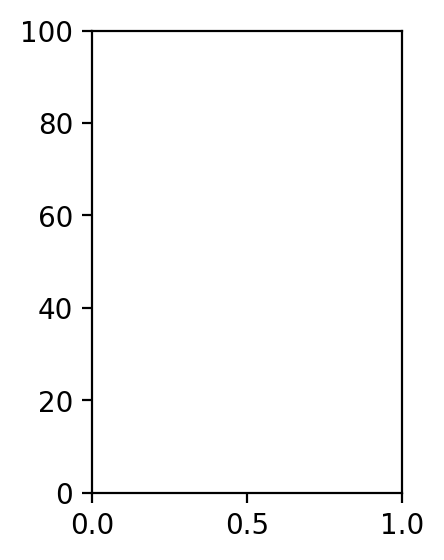

In [27]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 200)
plt.ylim((0,100))
violin_plot = sns.violinplot(data=df_nuclei[(df_nuclei['group'].str.contains('989_HS')) | (df_nuclei['group'].str.contains('989_L3'))], x="group", y="variance",legend = False,inner='box',width=1)
for item in violin_plot.get_xticklabels():
    item.set_rotation(45)
plt.legend([], [], frameon=False)
violin_plot.tick_params(labelsize=6)
#plt.margins(x=0.25)
plt.title('variance of signal between groups')

In [ ]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 200)
#plt.ylim((0,150))
violin_plot = sns.violinplot(data=df_nuclei[df_nuclei['group'].str.contains('PMW1066')], x="group", y="std",legend = False,inner='box',width=0.6)
for item in violin_plot.get_xticklabels():
    item.set_rotation(45)
plt.legend([], [], frameon=False)
violin_plot.tick_params(labelsize=6)
#plt.margins(x=0.25)
plt.title('variance of signal between groups')

In [ ]:
import seaborn as sns
plt.figure(figsize = (2,3),dpi = 200)
#plt.ylim((0,150))
violin_plot = sns.swarmplot(data=df_nuclei[df_nuclei['group'].str.contains('PMW989_animals')], x="group", y="std",legend = False)
for item in violin_plot.get_xticklabels():
    item.set_rotation(45)
plt.legend([], [], frameon=False)
violin_plot.tick_params(labelsize=6)
#plt.margins(x=0.25)
plt.title('variance of signal between groups')

In [ ]:
import seaborn as sns
plt.figure(figsize = (5,2),dpi = 200)
#plt.ylim((0,150))
violin_plot = sns.violinplot(data=df_nuclei[df_nuclei['group'].str.contains('PMW989_animals_hexanediol')], x="group", y="variance",hue='id',inner=None,width=0.6)
for item in violin_plot.get_xticklabels():
    item.set_rotation(45)
plt.legend(np.arange(1,13), [], frameon=False)
violin_plot.tick_params(labelsize=6)
#plt.margins(x=0.25)


In [ ]:
import seaborn as sns
plt.figure(figsize = (3,2),dpi = 200)
#plt.ylim((0,150))
violin_plot = sns.violinplot(data=df_nuclei[df_nuclei['group'].str.contains('PMW989_animals_hexanediol')], x="group", y="variance",hue='id',inner=None,width=0.9)
for item in violin_plot.get_xticklabels():
    item.set_rotation(0)
plt.legend(np.arange(1,13), [], frameon=False)
violin_plot.tick_params(labelsize=6)
plt.title('Variance of signal inside nuclei for each worm')
#plt.margins(x=0.25)

In [ ]:
import seaborn as sns
plt.figure(figsize = (30,5),dpi = 300)
plt.ylim((0,30000))
violin_plot = sns.violinplot(data=df_nuclei, x="group", y="volume", inner=None)
for item in violin_plot.get_xticklabels():
    item.set_rotation(90)
violin_plot.tick_params(labelsize=10)

In [ ]:
df_nuclei.groupby(['group'])['volume'].mean()

In [ ]:
df_nuclei.groupby(['group'])

In [ ]:
'import seaborn as sns
plt.figure(figsize = (30,5),dpi = 300)
plt.ylim((0,25000))
violin_plot = sns.violinplot(data=df_nuclei, x="group", y="volume", inner=None)
for item in violin_plot.get_xticklabels():
    item.set_rotation(90)
violin_plot.tick_params(labelsize=8)

In [ ]:
filt = df_nuclei[(df_nuclei['volume']<0.25e6)&(df_nuclei['median']>400)]

In [ ]:
plt.figure(figsize = (11,11))
plt.scatter(filt['volume'],filt['median'], alpha = 0.1)
plt.xlabel('volume')
plt.ylabel('median')

In [ ]:
import seaborn as sns
plt.figure(figsize = (30,5),dpi = 300)
plt.ylim((0,25000))
violin_plot = sns.violinplot(data=filt, x="group", y="volume", inner=None)
for item in violin_plot.get_xticklabels():
    item.set_rotation(90)
violin_plot.tick_params(labelsize=8)

In [ ]:
plt.figure(figsize = (11,11))
plt.scatter(filt['std'],filt['volume'], alpha = 0.1)

In [ ]:
plt.figure(dpi = 200)
plt.hist(df_nuclei.volume, bins = 200, range=(0, 28000))
plt.plot()

In [ ]:
plt.figure(figsize = (11,11))
plt.scatter(filt['volume'],filt['median'], alpha = 0.1)
plt.xlabel('volume')
plt.ylabel('median')

In [ ]:
mx.mask.shape

In [ ]:
34*35

In [ ]:
plt.imshow(df_region_props['intensity_image'][0][5])

In [ ]:
df_region_props['intensity_image'][0][5][0,0]

In [ ]:
index = 0
img = io.imread(df.filepath[index])




In [ ]:
img.shape

In [ ]:
masks,flows,styles = model.eval(img[:,1,:,:],do_3D=False,stitch_threshold=0.3,cellprob_threshold =0,diameter =36)

In [ ]:
# Segment nuclei 
masks,flows,styles = segment_nuclei(img[:,1,:,:],model) # Run the segmentation

io.imsave(output_path+'segmentation/'+df.id[index]+'.tif',masks,check_contrast=False) #store segmentation

